# atmodeller

## Science Cases

Following the Monte Carlo approach in 3_monte_carlo.ipynb, we sample the possible atmospheres of known exoplanets that can arise for different planetary conditions.


In [126]:
#from atmodeller import debug_logger
from typing import Type
from atmodeller.interior_atmosphere import InteriorAtmosphereSystem, Planet, Species
from atmodeller.constraints import MassConstraint, IronWustiteBufferConstraintHirschmann, IronWustiteBufferConstraintOneill, SystemConstraints, FugacityConstraint, PressureConstraint, TotalPressureConstraint
from atmodeller.eos.holland import (
    CO2_CORK_simple_HP91,
    CO2_MRK_simple_HP91,
    get_holland_eos_models,
)
from atmodeller.eos.saxena import (
    get_saxena_eos_models
)
from atmodeller.interfaces import (
    GasSpecies,
    IdealGas,
    NoSolubility,
    RealGasABC,
    ThermodynamicData,
    ThermodynamicDataBase,
)
from atmodeller.solubilities import PeridotiteH2O, BasaltDixonCO2, BasaltLibourelN2, BasaltDixonH2O, BasaltS2, BasaltH2, BasaltCO
from atmodeller.utilities import earth_oceans_to_kg
import numpy as np
import csv
from atmodeller import debug_logger
import logging

thermodynamic_data: Type[ThermodynamicDataBase] = ThermodynamicData

eos_models_HP: dict[str, RealGasABC] = get_holland_eos_models()
eos_models_SS: dict[str, RealGasABC] = get_saxena_eos_models()

logger = debug_logger()
logger.setLevel(logging.INFO)


In [53]:
#Plotting Tools:
import matplotlib
import matplotlib.pyplot as plt
plt.rc("savefig", dpi=300)
plt.rc('figure', dpi=300)
plt.rc('text', usetex=True)
plt.rc('font', size=15)
plt.rc('xtick', direction='in') 
plt.rc('ytick', direction='in')
plt.rc('xtick.major', pad=5) 
plt.rc('xtick.minor', pad=5)
plt.rc('ytick.major', pad=5) 
plt.rc('ytick.minor', pad=5)
plt.rc('lines', dotted_pattern = [0.5, 1.1])

font={'weight':'bold',
     'size': 15}
matplotlib.rc('font', **font)
plt.rcParams["figure.figsize"] = (7,5)

## Simulating Trappist-1 e

In [54]:
species: Species = Species()
species.append(GasSpecies(chemical_formula='H2O', solubility=BasaltDixonH2O()))
species.append(GasSpecies(chemical_formula='H2', solubility=BasaltH2()))
species.append(GasSpecies(chemical_formula='O2'))
species.append(GasSpecies(chemical_formula='CO'))
species.append(GasSpecies(chemical_formula='CO2', solubility=BasaltDixonCO2()))
species.append(GasSpecies(chemical_formula='N2', solubility=BasaltLibourelN2()))
species

[11:37:29 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: H2O (H2O)


[11:37:30 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: H2 (H2)
[11:37:30 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: O2 (O2)
[11:37:30 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: CO (CO)
[11:37:30 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: CO2 (CO2)
[11:37:30 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: N2 (N2)


Species([GasSpecies(chemical_formula='H2O', name_in_thermodynamic_data='H2O', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2O'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x11d4b5850>, output=None, solubility=<atmodeller.solubilities.BasaltDixonH2O object at 0x11d55af10>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='H2', name_in_thermodynamic_data='H2', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x11d38bd10>, output=None, solubility=<atmodeller.solubilities.BasaltH2 object at 0x11d436110>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='O2', name

In [55]:
planet: Planet = Planet(surface_temperature=270, mantle_mass = 3.249E24, surface_radius = 5.804E6)


[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Mantle mass (kg) = 3248999999999999788187648.000000
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Mantle melt fraction = 1.000000
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Core mass fraction = 0.295335
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Planetary radius (m) = 5804000.000000
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Planetary mass (kg) = 4610699520224821698887680.000000
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Surface temperature (K) = 270.000000
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Surface gravity (m/s^2) = 9.135193
[11:37:36 - atmodeller.interior_atmosphere - INFO     ] - Melt Composition = None


In [56]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

[11:37:39 - atmodeller.interior_atmosphere - INFO     ] - Creating an interior-atmosphere system
[11:37:39 - atmodeller.interior_atmosphere - INFO     ] - Creating a reaction network
[11:37:39 - atmodeller.interior_atmosphere - INFO     ] - Species = ['H2O', 'H2', 'O2', 'CO', 'CO2', 'N2']
[11:37:39 - atmodeller.interior_atmosphere - INFO     ] - Reactions = 
{0: '1.0 H2O + 1.0 CO = 1.0 H2 + 1.0 CO2', 1: '2.0 H2O = 2.0 H2 + 1.0 O2'}


### Vary fO2

In [65]:
species: Species = Species()
species.append(GasSpecies(chemical_formula='H2O', solubility=BasaltDixonH2O()))
species.append(GasSpecies(chemical_formula='H2', solubility=BasaltH2()))
species.append(GasSpecies(chemical_formula='O2'))
species.append(GasSpecies(chemical_formula='CO2', solubility=BasaltDixonCO2()))
species.append(GasSpecies(chemical_formula='CO', solubility=BasaltCO()))
species.append(GasSpecies(chemical_formula='S2', solubility=BasaltS2()))
species.append(GasSpecies(chemical_formula='SO2'))

species

[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: H2O (H2O)


[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: H2 (H2)
[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: O2 (O2)
[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: CO2 (CO2)
[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: CO (CO)
[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: S2 (S2)
[11:41:44 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: SO2 (SO2)


Species([GasSpecies(chemical_formula='H2O', name_in_thermodynamic_data='H2O', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2O'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x11ca6b650>, output=None, solubility=<atmodeller.solubilities.BasaltDixonH2O object at 0x11d4ca1d0>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='H2', name_in_thermodynamic_data='H2', thermodynamic_class=<class 'atmodeller.interfaces.ThermodynamicDataJANAF'>, formula=Formula('H2'), thermodynamic_data=<atmodeller.interfaces.ThermodynamicDataJANAF object at 0x11d620110>, output=None, solubility=<atmodeller.solubilities.BasaltH2 object at 0x11d075b50>, solid_melt_distribution_coefficient=0, eos=IdealGas(critical_temperature=1, critical_pressure=1, standard_state_pressure=1)),
         GasSpecies(chemical_formula='O2', name

In [122]:
planet: Planet = Planet(surface_temperature=2000, mantle_mass = 3.249E24, surface_radius = 5.804E6, mantle_melt_fraction=1)
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Mantle mass (kg) = 3248999999999999788187648.000000
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Mantle melt fraction = 1.000000
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Core mass fraction = 0.295335
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Planetary radius (m) = 5804000.000000
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Planetary mass (kg) = 4610699520224821698887680.000000
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Surface temperature (K) = 2000.000000
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Surface gravity (m/s^2) = 9.135193
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Melt Composition = None
[15:38:08 - atmodeller.interior_atmosphere - INFO     ] - Creating an interior-atmosphere system
[15:38:08 - atmodeller.interior_atmosphere - INFO     ]

In [120]:
#Vary fO2:
number_of_realisations: int = 9

number_Earth_oceans: float = 1
# Parameters are normally distributed between bounds.
fo2_shifts: np.ndarray = np.arange(-4, 5)
print(fo2_shifts)
print(len(fo2_shifts))
print(fo2_shifts[8])

[-4 -3 -2 -1  0  1  2  3  4]
9
4


In [127]:
# Store the output in a list.
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_H: float = earth_oceans_to_kg(1)
    mass_C: float = mass_H/2
    mass_S: float = mass_H/10
    fug_H: float = 50
    fug_C: float = 10
    fug_S: float = 1

    constraints: SystemConstraints = SystemConstraints([
        MassConstraint(species="H", value=mass_H),
        MassConstraint(species="C", value=mass_C),
        MassConstraint(species="S", value=mass_S),
        #FugacityConstraint(species="H2", value=fug_H),
        #FugacityConstraint(species="CO", value=fug_C),
        #FugacityConstraint(species="S2", value=fug_S),
        IronWustiteBufferConstraintOneill(log10_shift=fo2_shifts[realisation])
    ])
    # Recall that changing attributes on the planet 'object' will be 'seen' by interior_atmosphere.
    interior_atmosphere.solve(constraints, factor=1)
    #out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    
    H2_output = interior_atmosphere.output['H2'].pressure_in_atmosphere
    H2O_output = interior_atmosphere.output['H2O'].pressure_in_atmosphere
    O2_output = interior_atmosphere.output['O2'].pressure_in_atmosphere 

    H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt
    CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt
    S2_melt = interior_atmosphere.output['S2'].ppmw_in_melt

    out_realisation: dict[str,float] = interior_atmosphere.solution_dict

    # Include the parameters in the output.

    out_realisation['H2_melt'] = H2_melt
    out_realisation['H2O_melt'] = H2O_melt
    out_realisation['O2_melt'] = O2_melt
    out_realisation['CO2_melt'] = CO2_melt
    out_realisation['CO_melt'] = CO_melt
    out_realisation['S2_melt'] = S2_melt

    out_realisation['fo2_shift'] = fo2_shifts[realisation]

    out.append(out_realisation)

    filename: str = "data/science_cases_files/atmodeller_Trappist1e_varyfO2_CHOS.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)
    

[15:54:57 - atmodeller.interior_atmosphere - INFO     ] - Assembling constraints
[15:54:57 - atmodeller.interior_atmosphere - INFO     ] - Constraints: [MassConstraint(name='mass', species='H', value=1.5500015377899477e+20),
 MassConstraint(name='mass', species='C', value=7.750007688949739e+19),
 MassConstraint(name='mass', species='S', value=1.5500015377899477e+19),
 IronWustiteBufferConstraintOneill(name='fugacity',
                                   species='O2',
                                   log10_shift=-4)]
/Users/maggiethompson/Programs/atmodeller/atmodeller/interior_atmosphere.py:575: RuntimeWarning: overflow encountered in power
  return 10**self.log_solution
[15:54:57 - atmodeller.interior_atmosphere - INFO     ] - 3 additional (mass) constraint(s) are necessary to solve the system
[15:54:57 - atmodeller.interior_atmosphere - INFO     ] - Apply fugacity constraint for O2
[15:54:57 - atmodeller.interior_atmosphere - INFO     ] - Row 00: Reaction 0: 1.0 CO2 = 0.5 O2 + 1.0 C

SystemExit: 

/Users/maggiethompson/Programs/atmodeller/.venv/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3516: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


In [113]:
import pandas as pd
datafile_fO2: str = f"data/science_cases_files/atmodeller_Trappist1e_varyfO2_CHOS.csv"
df_fO2: pd.DataFrame = pd.read_csv(datafile_fO2, skiprows=1, names=('H2O_pp', 'H2_pp', 'O2_pp', 'CO2_pp', 'CO_pp', 'S2_pp', 'SO2_pp', 'H2O_melt', 'H2_melt', 'O2_melt', 'CO2_melt', 'CO_melt', 'S2_melt', 'fO2_shift'))

print(df_fO2.fO2_shift)

0   -4
1   -3
2   -2
3   -1
4    0
5    1
6    2
7    3
8    4
Name: fO2_shift, dtype: int64


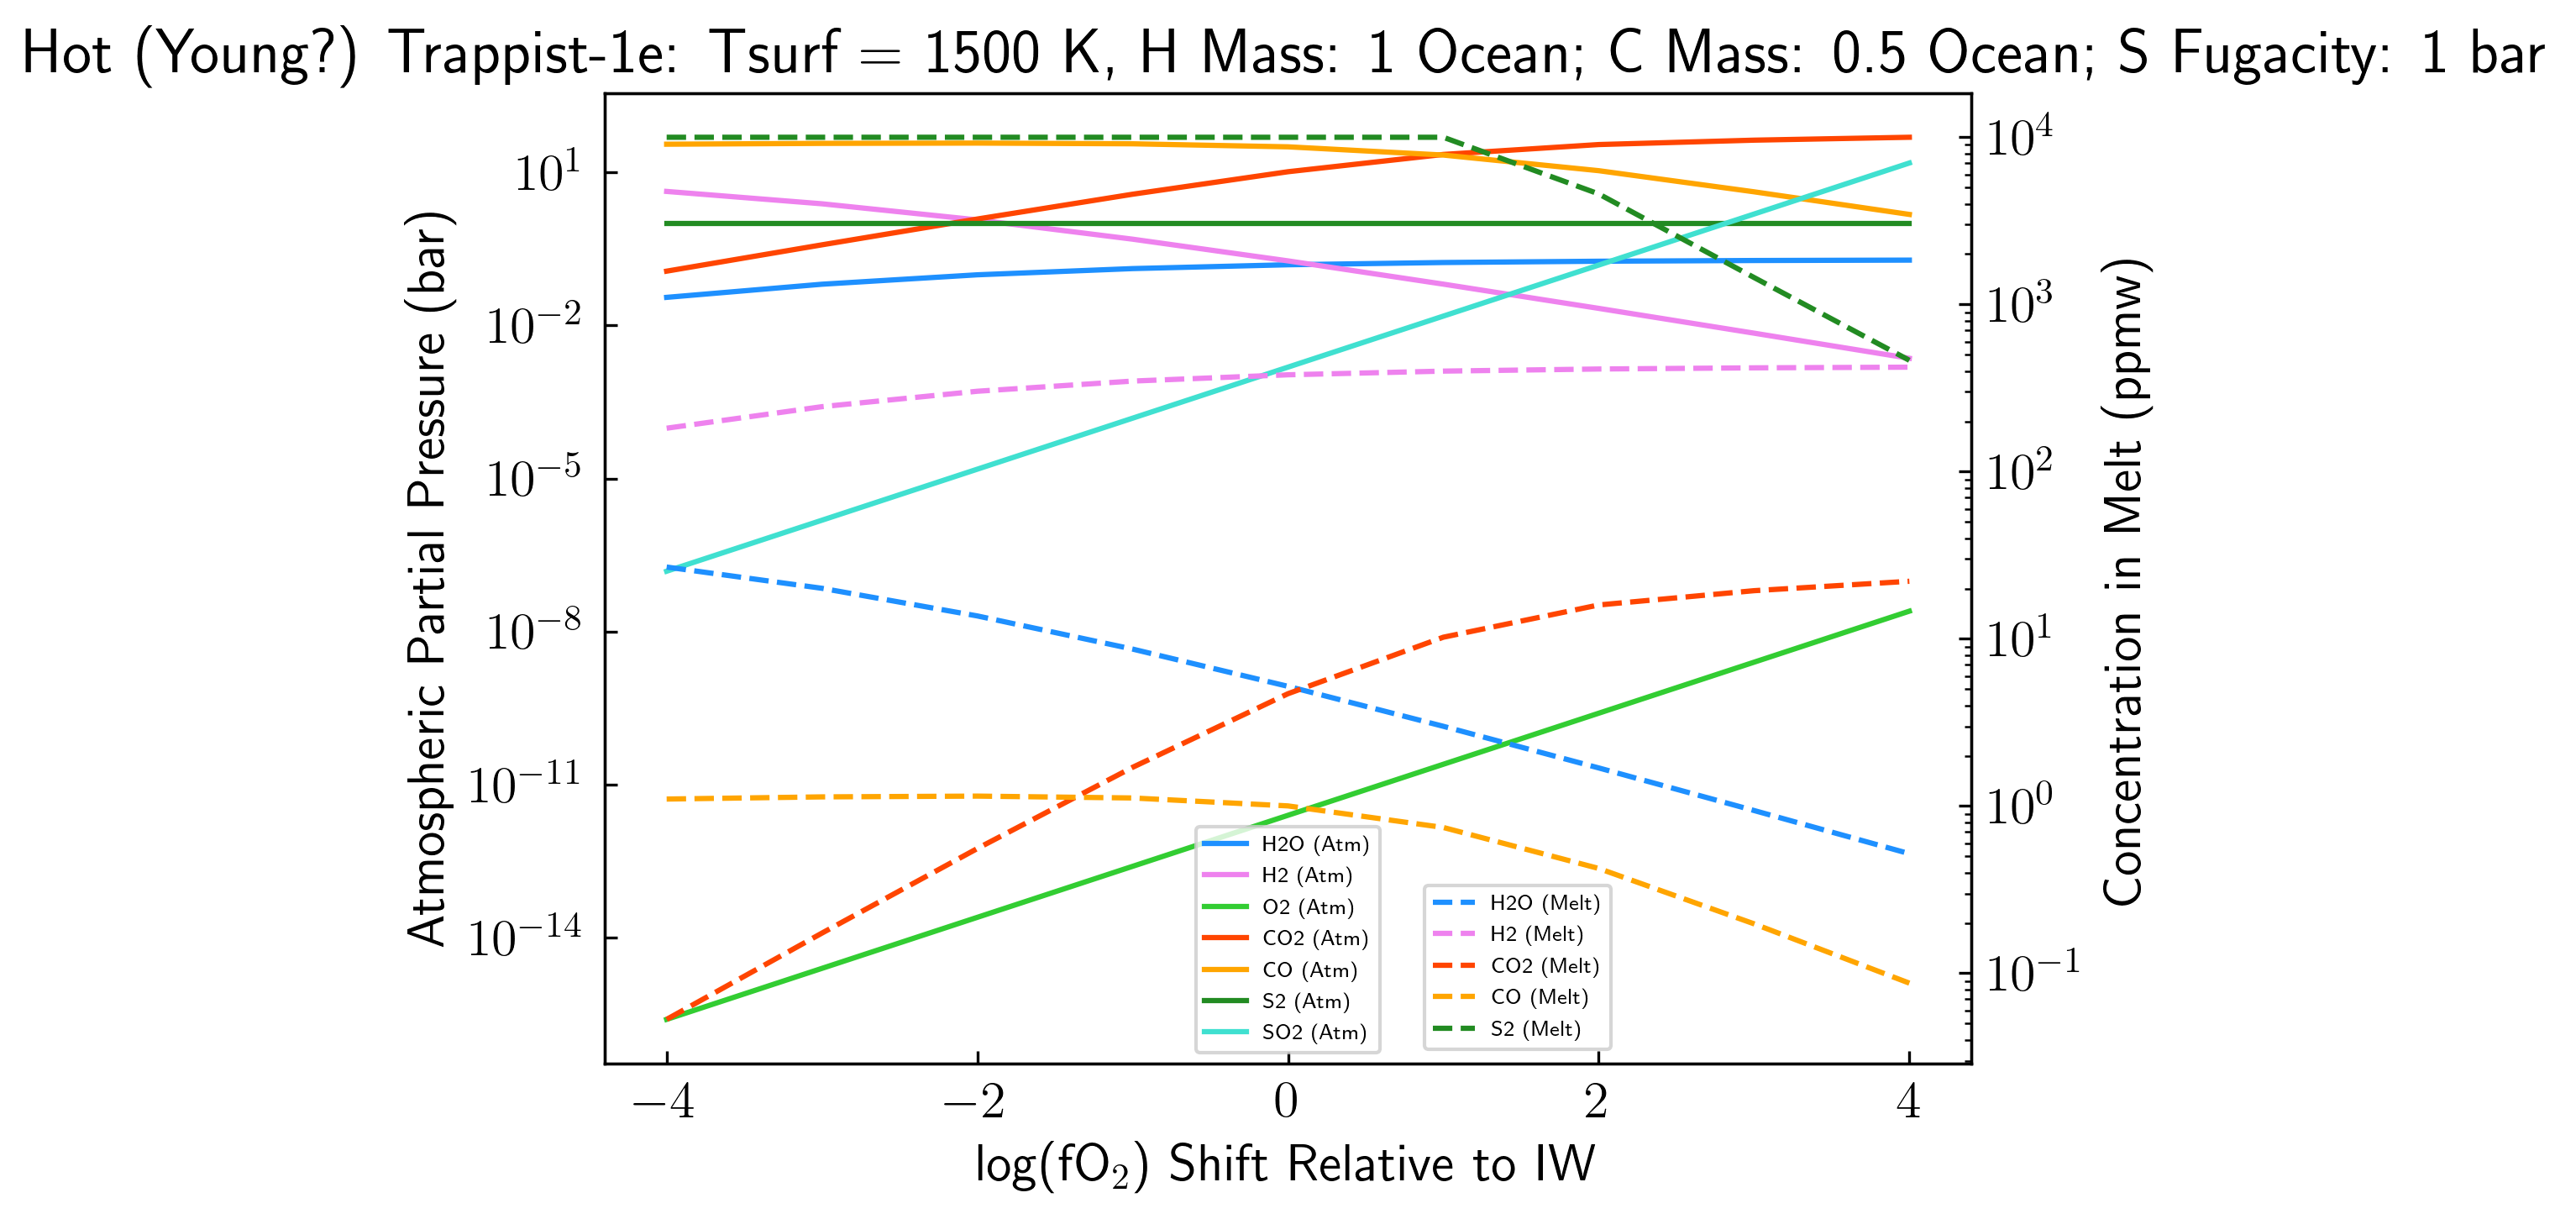

In [115]:
fig, ax = plt.subplots()
ax.plot(df_fO2.fO2_shift, df_fO2.H2O_pp, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.H2_pp, color='violet', label='H2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.O2_pp, color='limegreen', label='O2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO2_pp, color='orangered', label='CO2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO_pp, color='orange', label='CO (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.S2_pp, color='forestgreen', label='S2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.SO2_pp, color='turquoise', label='SO2 (Atm)')


ax2 = ax.twinx()
ax2.plot(df_fO2.fO2_shift, df_fO2.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.CO_melt, color='orange', linestyle='--', label='CO (Melt)')
ax2.plot(df_fO2.fO2_shift, df_fO2.S2_melt, color='forestgreen', linestyle='--', label='S2 (Melt)')

ax.set_xlabel(r'log(fO$_2$) Shift Relative to IW')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax2.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
#ax.set_ylim(1e-16, 1e5)
ax2.set_yscale('log')
#ax2.set_ylim(1e-2, 1e5)
ax.legend(fontsize=6, loc=8)
ax2.legend(fontsize=6, loc=(0.6, 0.015))

plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 1500 K, H Mass: 1 Ocean; C Mass: 0.5 Ocean; S Fugacity: 1 bar')
plt.savefig('data/Plots/PlanetTrial1_HotTrappist1e_CHOS_1500K_massH_1_Ocean_massC_p5_Ocean_fugS_1.jpg', dpi=1000, bbox_inches='tight')
plt.show()

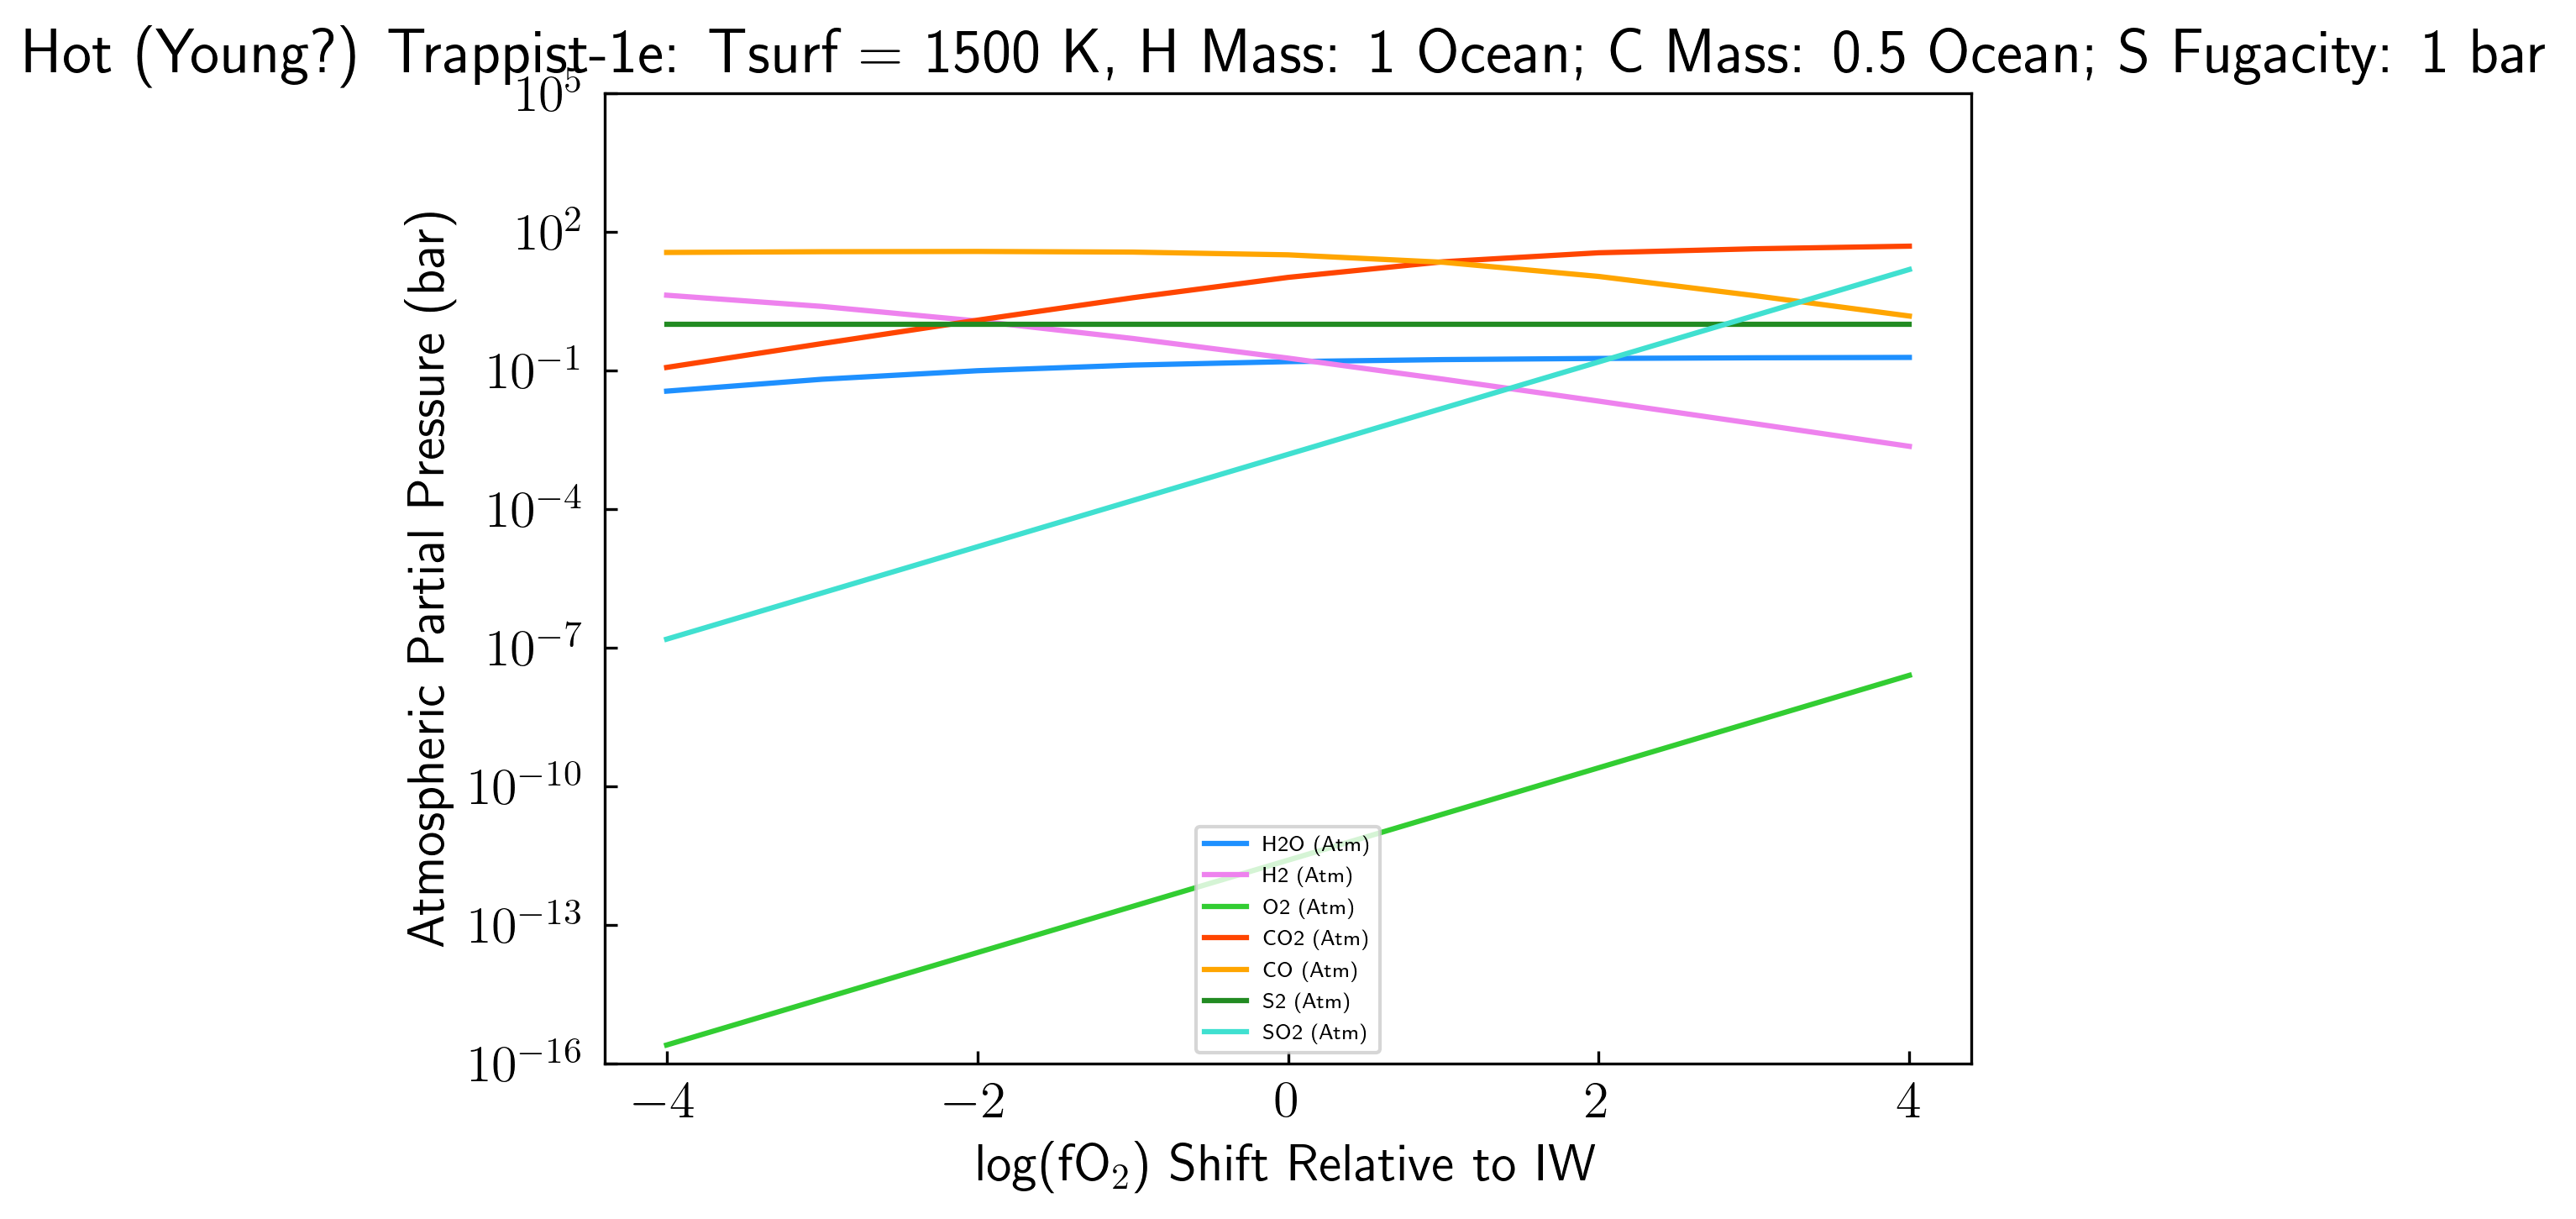

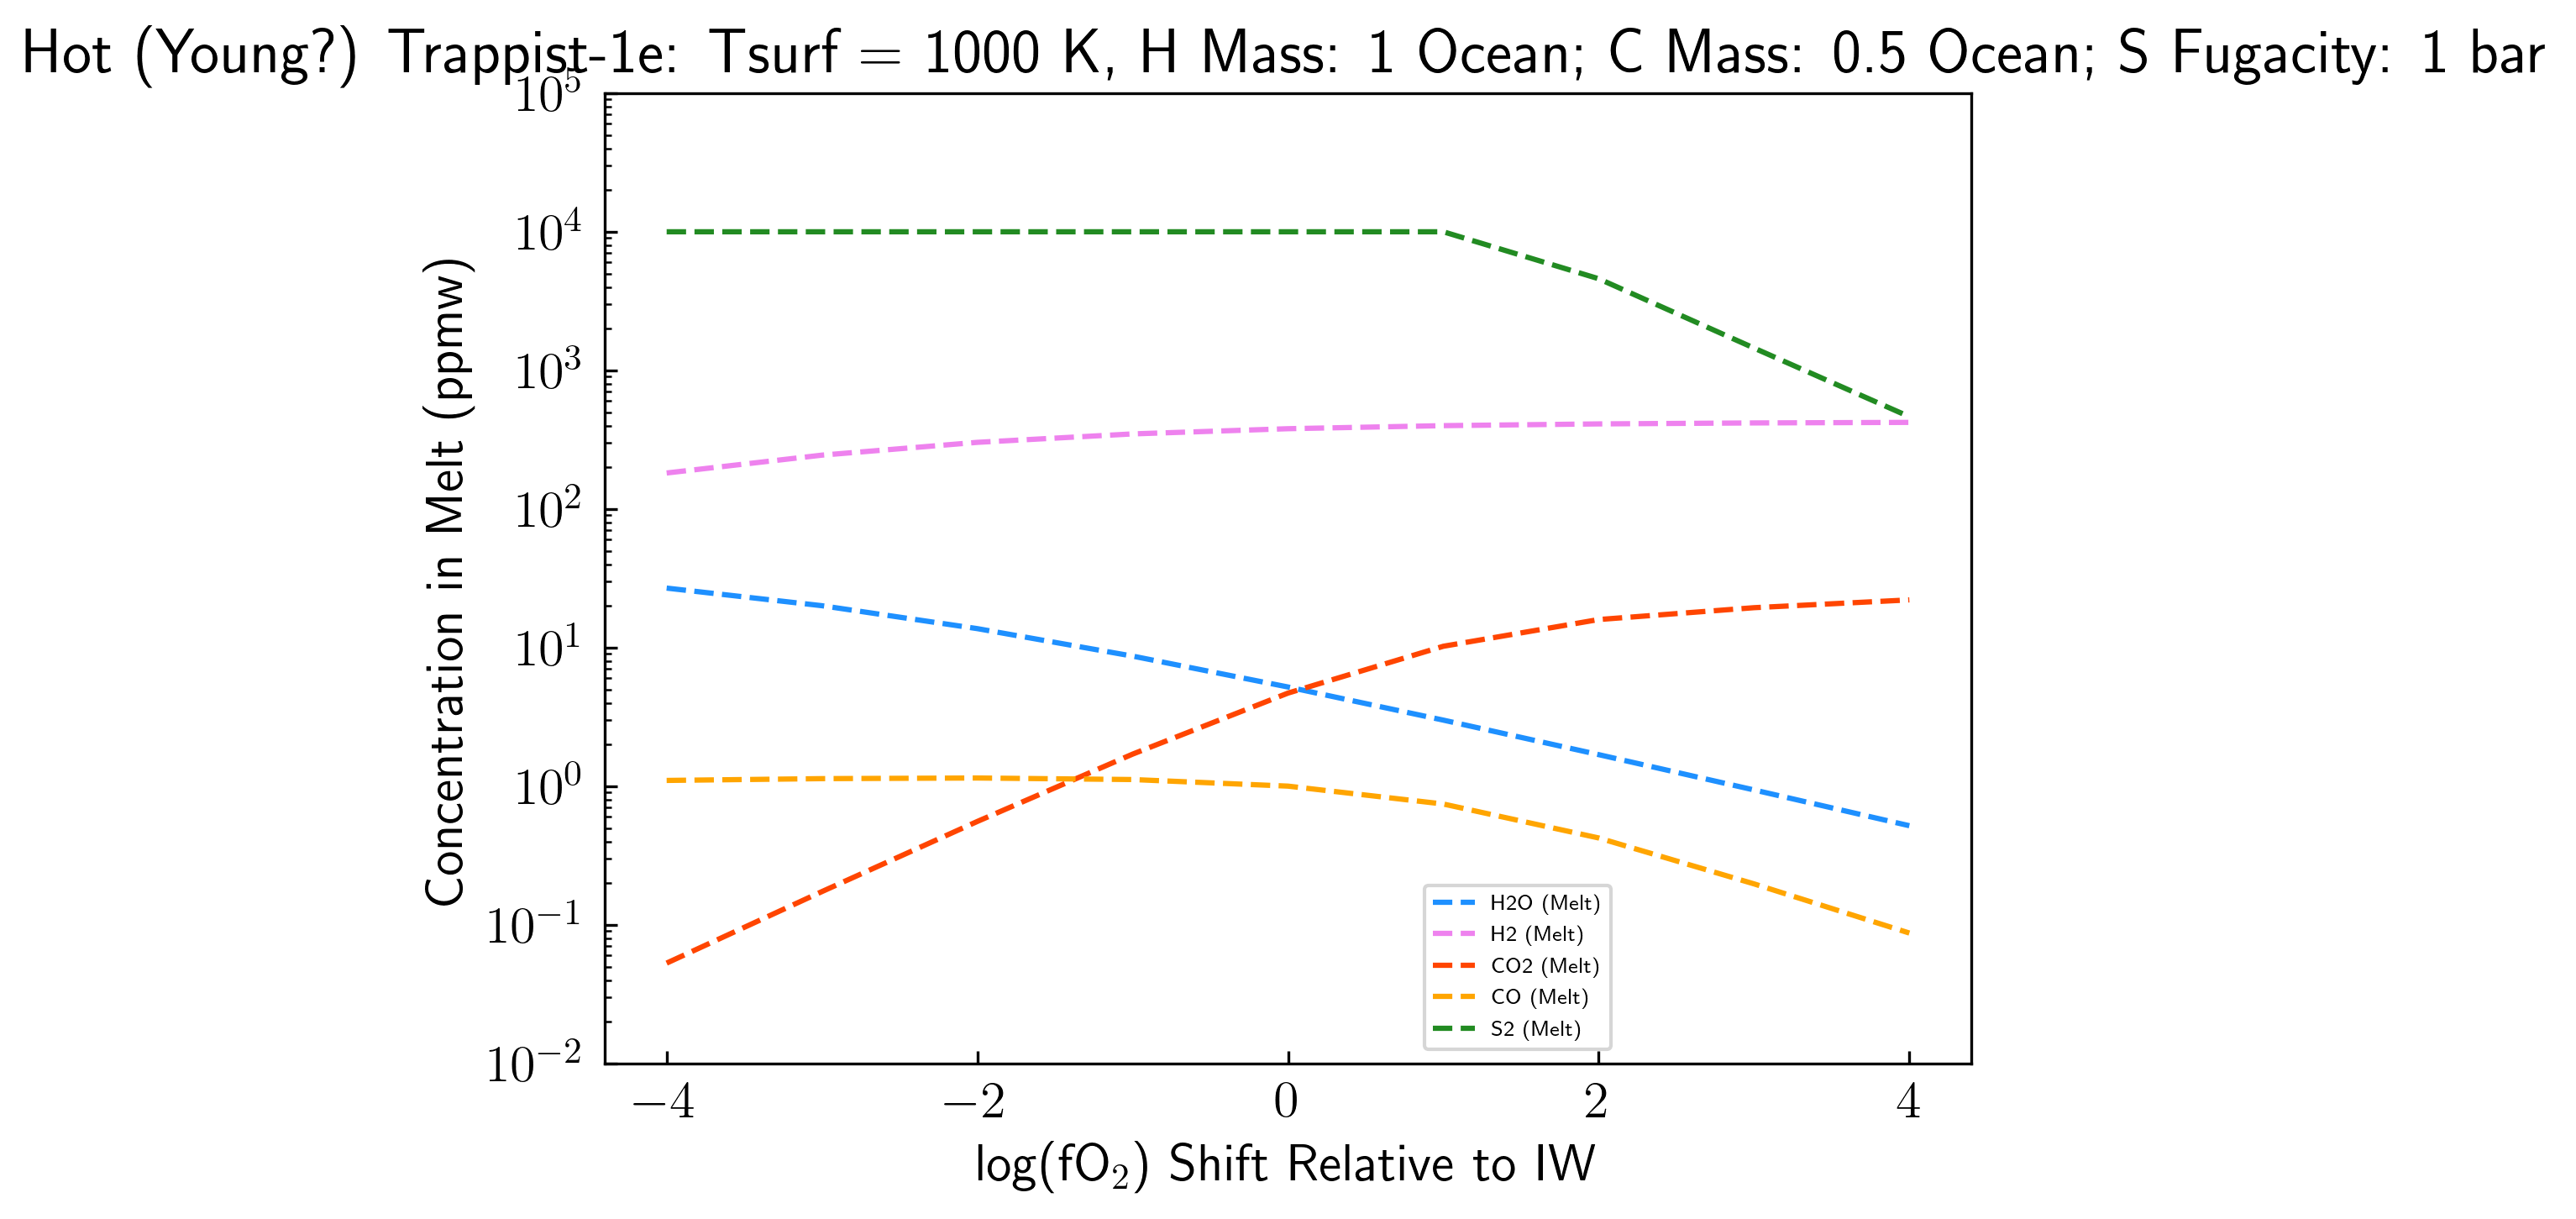

In [116]:
fig, ax = plt.subplots()
ax.plot(df_fO2.fO2_shift, df_fO2.H2O_pp, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.H2_pp, color='violet', label='H2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.O2_pp, color='limegreen', label='O2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO2_pp, color='orangered', label='CO2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO_pp, color='orange', label='CO (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.S2_pp, color='forestgreen', label='S2 (Atm)')
ax.plot(df_fO2.fO2_shift, df_fO2.SO2_pp, color='turquoise', label='SO2 (Atm)')

ax.set_xlabel(r'log(fO$_2$) Shift Relative to IW')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
ax.set_yscale('log')
ax.set_ylim(1e-16, 1e5)
ax.legend(fontsize=6, loc=8)
plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 1500 K, H Mass: 1 Ocean; C Mass: 0.5 Ocean; S Fugacity: 1 bar')
plt.savefig('data/Plots/PlanetTrial1_HotTrappist1e_CHOS_1500K_massH_1_Ocean_massC_p5_Ocean_fugS_1.jpg', dpi=1000, bbox_inches='tight')
plt.show()

fig, ax = plt.subplots()

ax.plot(df_fO2.fO2_shift, df_fO2.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax.plot(df_fO2.fO2_shift, df_fO2.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
ax.plot(df_fO2.fO2_shift, df_fO2.CO_melt, color='orange', linestyle='--', label='CO (Melt)')
ax.plot(df_fO2.fO2_shift, df_fO2.S2_melt, color='forestgreen', linestyle='--', label='S2 (Melt)')
ax.set_ylabel('Concentration in Melt (ppmw)')
ax.set_yscale('log')
ax.set_ylim(1e-2, 1e5)
ax.set_xlabel(r'log(fO$_2$) Shift Relative to IW')
ax.legend(fontsize=6, loc=(0.6, 0.015))
#plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 2000 K, M = 0.7M$_\oplus$, R = 0.9 R$_\oplus$')
plt.title(r'Hot (Young?) Trappist-1e: Tsurf = 1000 K, H Mass: 1 Ocean; C Mass: 0.5 Ocean; S Fugacity: 1 bar')

plt.savefig('data/Plots/PlanetTrial1_HotTrappist1e_CHOS_1500K_massH_1_Ocean_massC_p5_Ocean_fugS_1.jpg', dpi=1000, bbox_inches='tight')

plt.show()

## Simulating K2-18 b

In [26]:
planet: Planet = Planet(surface_temperature=1500, mantle_mass = 3.6315E25, surface_radius = 1.6647E7)
#planet: Planet = Planet()


[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Creating a new planet
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Mantle mass (kg) = 36315000000000001830813696.000000
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Mantle melt fraction = 1.000000
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Core mass fraction = 0.295335
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Planetary radius (m) = 16647000.000000
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Planetary mass (kg) = 51535104055698495989874688.000000
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Surface temperature (K) = 1500.000000
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Surface gravity (m/s^2) = 12.411862
[14:37:27 - atmodeller.interior_atmosphere - INFO     ] - Melt Composition = None


In [27]:
species: Species = Species(
        [
            GasSpecies(
                chemical_formula="H2",
                solubility=BasaltH2(),
                thermodynamic_class=thermodynamic_data,
                eos=eos_models_SS["H2"],
            ),
            GasSpecies(
                chemical_formula="H2O",
                solubility=BasaltDixonH2O(),
                thermodynamic_class=thermodynamic_data,
                eos=eos_models_HP["H2O"],
            ),
            GasSpecies(
                chemical_formula="O2",
                solubility=NoSolubility(),
                thermodynamic_class=thermodynamic_data,
                eos=eos_models_SS["O2"]
            ),
            #GasSpecies(
            #    chemical_formula="CO",
            #    solubility=BasaltCO(),
            #    thermodynamic_class=thermodynamic_data,
                #eos=eos_models_HP["CO"],
            #),
            #GasSpecies(
            #    chemical_formula="CO2",
            #    solubility=BasaltDixonCO2(),
            #    thermodynamic_class=thermodynamic_data,
            #    #eos=eos_models_HP["CO2"],
            #),
            #GasSpecies(
            #    chemical_formula="CH4",
            #    solubility=NoSolubility(),
            #    thermodynamic_class=thermodynamic_data,
            #    #eos=eos_models_HP["CH4"],
            #),
        ]
    )

[14:38:00 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: H2 (H2)
[14:38:00 - atmodeller.interfaces          - INFO     ] - Adding thermodynamic data: Holland and Powell
[14:38:00 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[14:38:00 - atmodeller.interfaces          - INFO     ] - Adding thermodynamic data: JANAF
[14:38:00 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: H2O (H2O)
[14:38:00 - atmodeller.interfaces          - INFO     ] - Adding thermodynamic data: Holland and Powell
[14:38:00 - atmodeller.interfaces          - WARNING  ] - Combining different thermodynamic data may result in inconsistencies
[14:38:00 - atmodeller.interfaces          - INFO     ] - Adding thermodynamic data: JANAF
[14:38:00 - atmodeller.interfaces          - INFO     ] - Creating a GasSpecies: O2 (O2)
[14:38:00 - atmodeller.interfaces          - INFO     ] - Adding thermodynamic data: Ho

In [70]:
oceans: float = 10
h_kg: float = earth_oceans_to_kg(oceans)
c_kg: float = h_kg

constraints: SystemConstraints = SystemConstraints(
    [
        FugacityConstraint(species="H2", value=958),
        IronWustiteBufferConstraintHirschmann(),
        MassConstraint(species="C", value=c_kg),
    ]
)

system: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

In [71]:
initial_solution: np.ndarray = np.array([1000, 1000, 1e-8, 100, 10, 1])
system.solve(constraints, initial_solution=initial_solution)

In [72]:
system.output

{'temperature': 2000,
 'total_pressure_in_atmosphere': 2026.6981086063047,
 'mean_molar_mass_in_atmosphere': 0.010667466253504542,
 'H2': GasSpeciesOutput(mass_in_atmosphere=5.079421345277659e+21, mass_in_solid=0.0, mass_in_melt=1.6732962580062393e+22, moles_in_atmosphere=2.5197017212702226e+24, moles_in_melt=8.30056649152202e+24, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=460.7727545108741, fugacity=957.9999999999998, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=958.0000000000001, volume_mixing_ratio=0.47269003505351176, mass_in_total=2.1812383925340054e+22),
 'H2O': GasSpeciesOutput(mass_in_atmosphere=4.900071852467356e+22, mass_in_solid=0.0, mass_in_melt=1.1269436003070279e+24, moles_in_atmosphere=2.7199521453459807e+24, moles_in_melt=6.255485134969139e+25, moles_in_solid=0.0, ppmw_in_solid=0.0, ppmw_in_melt=31032.454916894614, fugacity=1034.1359587308082, fugacity_coefficient=0.9999999999999997, pressure_in_atmosphere=1034.1359587308086, volume_mixing_ra

In [28]:
interior_atmosphere: InteriorAtmosphereSystem = InteriorAtmosphereSystem(species=species, planet=planet)

[14:38:18 - atmodeller.interior_atmosphere - INFO     ] - Creating an interior-atmosphere system
[14:38:18 - atmodeller.interior_atmosphere - INFO     ] - Creating a reaction network
[14:38:18 - atmodeller.interior_atmosphere - INFO     ] - Species = ['H2', 'H2O', 'O2']
[14:38:18 - atmodeller.interior_atmosphere - INFO     ] - Reactions = 
{0: '2.0 H2O = 2.0 H2 + 1.0 O2'}


In [29]:
#Vary amount of H (expressed as Earth oceans)

number_of_realisations: int = 191

number_Earth_oceans_arr: np.ndarray = np.arange(1,16)

#print(number_Earth_oceans_arr)

#Vary abount of H in atmosphere:
H2_fugacity_arr: np.ndarray = np.arange(1000, 20100, 100)
print((float(H2_fugacity_arr[0])))

1000.0


In [71]:
#intial solution array:

CO2_fugacity_arr: np.ndarray = 5*np.ones(191)


191


In [ ]:
out: list[dict[str, float]] = []

for realisation in range(number_of_realisations):

    mass_C: float = earth_oceans_to_kg(10)
    H2_fug = H2_fugacity_arr[realisation]
    constraints: SystemConstraints = SystemConstraints([
        FugacityConstraint(species="H2", value=H2_fug),
        #IronWustiteBufferConstraintHirschmann(),
        FugacityConstraint(species="H2O", value=1000),
        #FugacityConstraint(species="CO2", value=5),
    ])
    
    initial_solution: np.ndarray = np.array([H2_fug, 1000, 1e-13])
    # Recall that changing attributes on the planet 'object' will be 'seen' by interior_atmosphere.
    interior_atmosphere.solve(constraints, factor=1, tol = 1e-6)
    #out_realisation: dict[str,float] = interior_atmosphere.solution_dict
    Total_P = interior_atmosphere.output['total_pressure_in_atmosphere']
    H2_fug = interior_atmosphere.output['H2'].fugacity
    H2O_fug = interior_atmosphere.output['H2O'].fugacity
    O2_fug = interior_atmosphere.output['O2'].fugacity

    H2_mass = interior_atmosphere.output['H2'].mass_in_atmosphere
    H2O_mass = interior_atmosphere.output['H2O'].mass_in_atmosphere
    O2_mass = interior_atmosphere.output['O2'].mass_in_atmosphere 

    H2_melt = interior_atmosphere.output['H2'].ppmw_in_melt
    H2O_melt = interior_atmosphere.output['H2O'].ppmw_in_melt
    O2_melt = interior_atmosphere.output['O2'].ppmw_in_melt

    H2_melt_mass= interior_atmosphere.output['H2'].mass_in_melt
    H2O_melt_mass = interior_atmosphere.output['H2O'].mass_in_melt
    O2_melt_mass = interior_atmosphere.output['O2'].mass_in_melt

    H2_totalmass = interior_atmosphere.output['H2'].mass_in_total
    H2O_totalmass = interior_atmosphere.output['H2O'].mass_in_total
    O2_totalmass = interior_atmosphere.output['O2'].mass_in_total
    #CO2_melt = interior_atmosphere.output['CO2'].ppmw_in_melt
    #CO_melt = interior_atmosphere.output['CO'].ppmw_in_melt

    out_realisation: dict[str,float] = interior_atmosphere.solution_dict

    # Include the parameters in the output.

    out_realisation['H2_melt'] = H2_melt
    out_realisation['H2O_melt'] = H2O_melt
    out_realisation['O2_melt'] = O2_melt
    #out_realisation['CO2_melt'] = CO2_melt
    #out_realisation['CO_melt'] = CO_melt
    out_realisation['H2_mass_atm'] = H2_mass
    out_realisation['H2O_mass_atm'] = H2O_mass
    out_realisation['O2_mass_atm'] = O2_mass

    out_realisation['H2_mass_melt'] = H2_melt_mass
    out_realisation['H2O_mass_melt'] = H2O_melt_mass
    out_realisation['O2_mass_melt'] = O2_melt_mass  

    out_realisation['H2_mass_tot'] = H2_totalmass
    out_realisation['H2O_mass_tot'] = H2O_totalmass
    out_realisation['O2_mass_tot'] = O2_totalmass   

    out_realisation['H2_fugacity'] = H2_fug     
    out_realisation['H2O_fugacity'] = H2O_fug
    out_realisation['O2_fugacity'] = O2_fug


    out_realisation['H2_fugacity_input'] = H2_fugacity_arr[realisation]
    out_realisation['Total_Pressure']=Total_P

    out.append(out_realisation)

    filename: str = "data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_RealGas_1500K.csv"
    print("Writing output to: %s", filename)
    fieldnames: list[str] = list(out[0].keys())
    with open(filename, "w", newline="", encoding="utf-8") as csvfile:
        writer: csv.DictWriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        writer.writerows(out)

#### Analyze Results

In [47]:
import pandas as pd
datafile_K218b_R: str = f"data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_RealGas_1500K.csv"
#df_K218b_try: pd.DataFrame = pd.read_csv(datafile_K218b_try, skiprows=1, names=('H2','H2O','O2','CO','CO2','CH4','H2_melt','H2O_melt','O2_melt','CO2_melt','CO_melt','H2_fugacity'))
df_K218b_R: pd.DataFrame = pd.read_csv(datafile_K218b_R, skiprows=1, names=('H2','H2O','O2','H2_melt','H2O_melt','O2_melt','H2_mass_atm', 'H2O_mass_atm', 'O2_mass_atm', 
                                                                                'H2_mass_melt', 'H2O_mass_melt', 'O2_mass_melt', 'H2_mass_tot', 'H2O_mass_tot', 'O2_mass_tot', 'H2_fug', 'H2O_fug', 'O2_fug', 'H2_fugacity_input', 'Total_Pressure'))

datafile_K218b_I: str = f"data/science_cases_files/atmodeller_K218b_varyH2Pto2GPa_IdealGas_1500K.csv"
#df_K218b_try: pd.DataFrame = pd.read_csv(datafile_K218b_try, skiprows=1, names=('H2','H2O','O2','CO','CO2','CH4','H2_melt','H2O_melt','O2_melt','CO2_melt','CO_melt','H2_fugacity'))
df_K218b_I: pd.DataFrame = pd.read_csv(datafile_K218b_I, skiprows=1, names=('H2','H2O','O2','H2_melt','H2O_melt','O2_melt','H2_mass_atm', 'H2O_mass_atm', 'O2_mass_atm', 
                                                                                'H2_mass_melt', 'H2O_mass_melt', 'O2_mass_melt', 'H2_mass_tot', 'H2O_mass_tot', 'O2_mass_tot', 'H2_fugacity', 'Total_Pressure'))

print(df_K218b_R)

              H2         H2O  ...  H2_fugacity_input  Total_Pressure
0     851.411035  973.079766  ...               1000     1824.490801
1     929.433804  970.253534  ...               1100     1899.687338
2    1006.336339  967.367074  ...               1200     1973.703413
3    1082.160749  964.367766  ...               1300     2046.528515
4    1156.939867  961.286914  ...               1400     2118.226782
..           ...         ...  ...                ...             ...
186  8196.285195  580.521951  ...              19600     8776.807146
187  8219.542827  579.359991  ...              19700     8798.902818
188  8242.718754  578.203786  ...              19800     8820.922540
189  8265.813583  577.053289  ...              19900     8842.866872
190  8288.827913  575.908456  ...              20000     8864.736369

[191 rows x 20 columns]


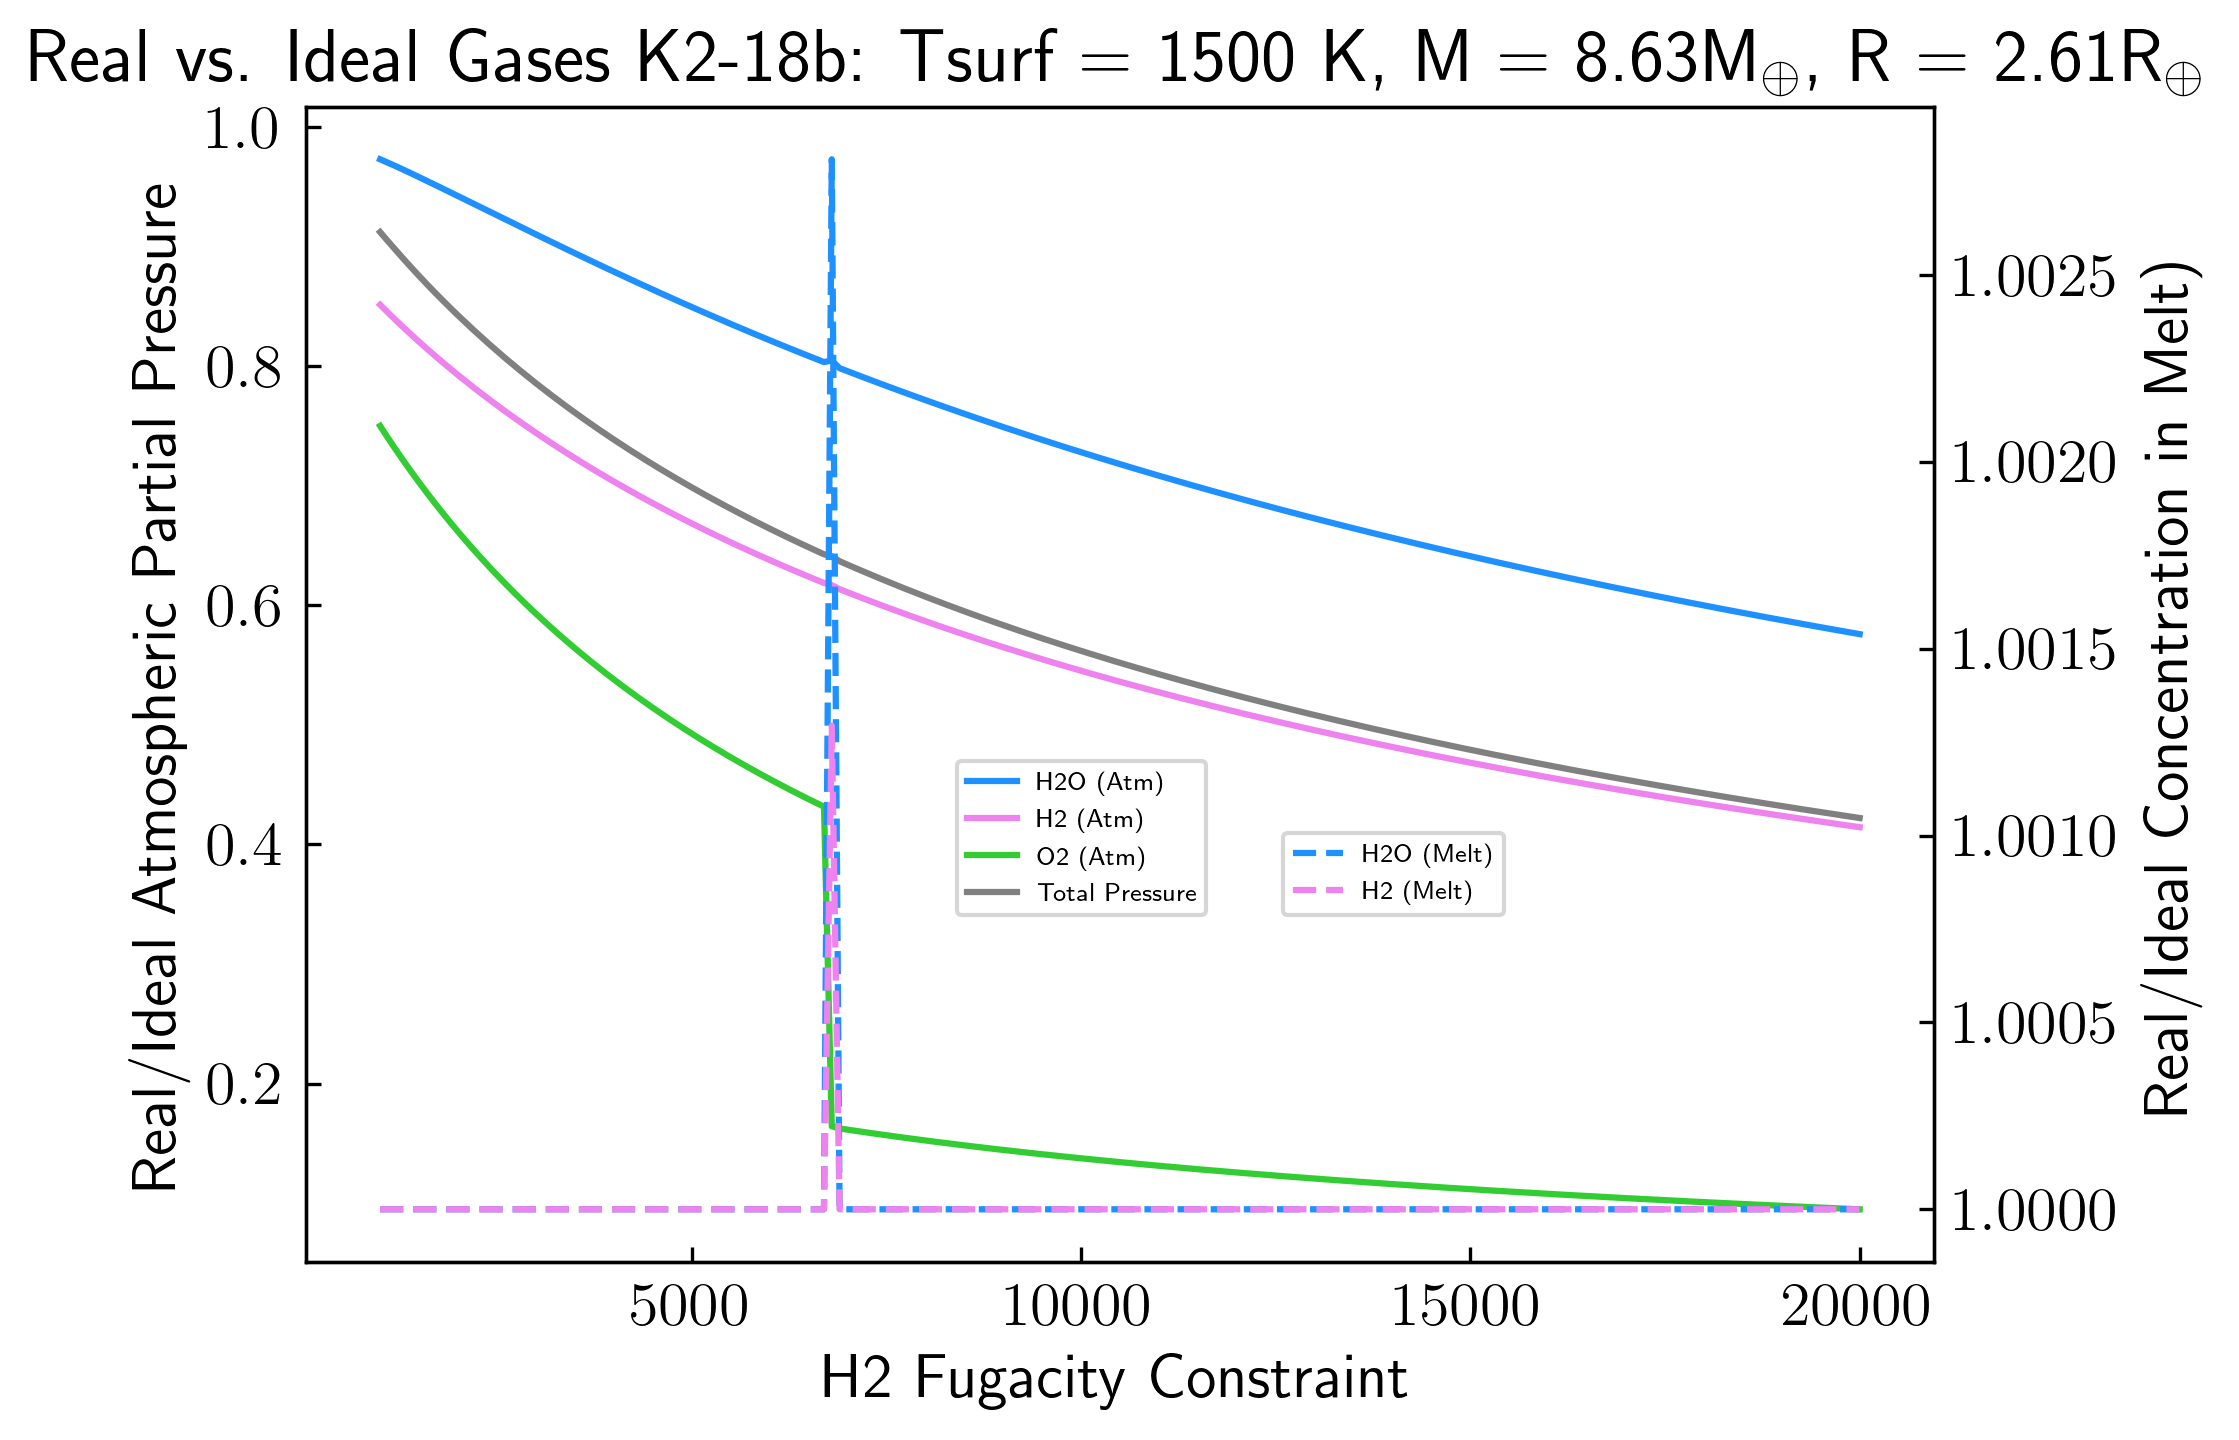

In [38]:
fig, ax = plt.subplots()
ax.plot(df_K218b_I.H2_fugacity, df_K218b_R.H2O/df_K218b_I.H2O, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_K218b_I.H2_fugacity, df_K218b_R.H2/df_K218b_I.H2, color='violet', label='H2 (Atm)')
ax.plot(df_K218b_I.H2_fugacity, df_K218b_R.O2/df_K218b_I.O2, color='limegreen', label='O2 (Atm)')
ax.plot(df_K218b_I.H2_fugacity, df_K218b_R.Total_Pressure/df_K218b_I.Total_Pressure, color='gray', label='Total Pressure')
#ax.plot(df_K218b_try.H2, df_K218b_try.CO2, color='orangered', label='CO2 (Atm)')
#ax.plot(df_K218b_try.H2, df_K218b_try.CO, color='orange', label='CO (Atm)')
#ax.plot(df_K218b_try.H2, df_K218b_try.CH4, color='deeppink', label='CH4 (Atm)')


ax2 = ax.twinx()
ax2.plot(df_K218b_I.H2_fugacity, df_K218b_R.H2O_melt/df_K218b_I.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
ax2.plot(df_K218b_I.H2_fugacity, df_K218b_R.H2_melt/df_K218b_I.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
#ax2.plot(df_fO2.fO2_shift, df_fO2.O2_melt, color='limegreen', linestyle='--', label='O2 (Melt)')
#ax2.plot(df_K218b_try.H2, df_K218b_try.CO2_melt, color='orangered', linestyle='--', label='CO2 (Melt)')
#ax2.plot(df_K218b_try.H2, df_K218b_try.CO_melt, color='orange', linestyle='--', label='CO (Melt)')
#ax.axvline(x=7500, color='gray', alpha=0.5)

ax.set_xlabel(r'H2 Fugacity Constraint')
ax.set_ylabel('Real/Ideal Atmospheric Partial Pressure')
ax2.set_ylabel('Real/Ideal Concentration in Melt)')
#ax.set_yscale('log')
#ax2.set_yscale('log')

ax.legend(fontsize=6, loc=(0.4, 0.3))
ax2.legend(fontsize=6, loc=(0.6, 0.3))
plt.title(r'Real vs. Ideal Gases K2-18b: Tsurf = 1500 K, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
plt.savefig('data/Plots/K218b_HO_1500K_RealvsIdealGas_Pupto2GPa.jpg', dpi=1000, bbox_inches='tight')
plt.show()

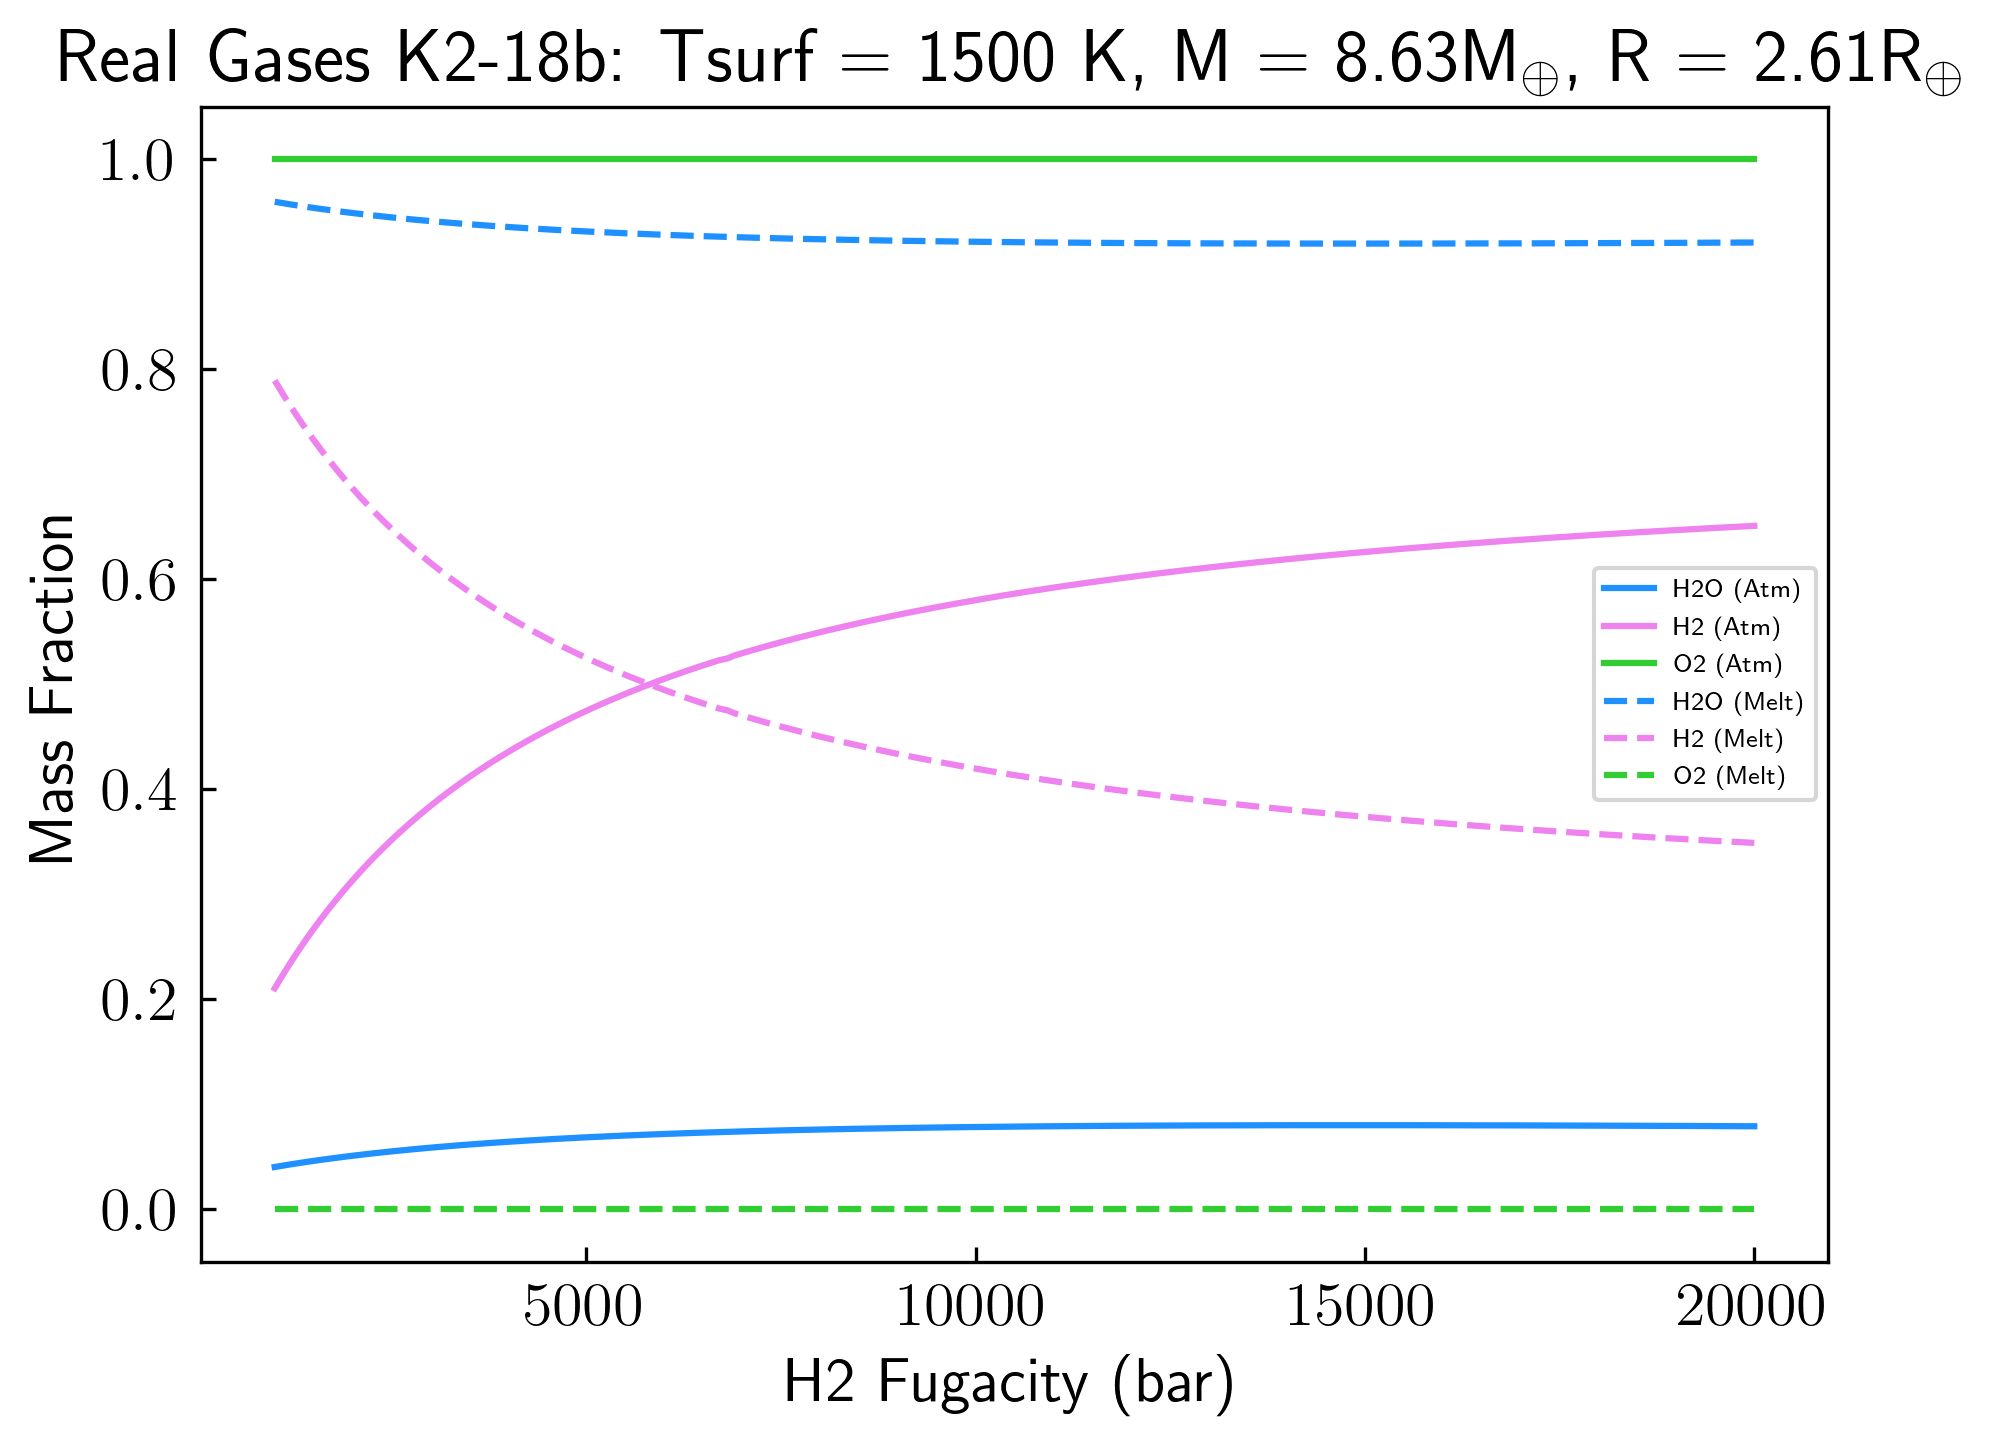

In [51]:
fig, ax = plt.subplots()
ax.plot(df_K218b_R.H2_fug, df_K218b_R.H2O_mass_atm/df_K218b_R.H2O_mass_tot, color='dodgerblue', label='H2O (Atm)')
ax.plot(df_K218b_R.H2_fug, df_K218b_R.H2_mass_atm/df_K218b_R.H2_mass_tot, color='violet', label='H2 (Atm)')
ax.plot(df_K218b_R.H2_fug, df_K218b_R.O2_mass_atm//df_K218b_R.O2_mass_tot, color='limegreen', label='O2 (Atm)')

ax.plot(df_K218b_R.H2_fug, df_K218b_R.H2O_mass_melt/df_K218b_R.H2O_mass_tot, color='dodgerblue', ls='--', label='H2O (Melt)')
ax.plot(df_K218b_R.H2_fug, df_K218b_R.H2_mass_melt/df_K218b_R.H2_mass_tot, color='violet', ls='--', label='H2 (Melt)')
ax.plot(df_K218b_R.H2_fug, df_K218b_R.O2_mass_melt/df_K218b_R.O2_mass_tot, color='limegreen', ls='--',  label='O2 (Melt)')
#ax.plot(df_K218b_try.H2, df_K218b_try.Total_Pressure, color='gray', label='Total Pressure')


ax.set_xlabel(r'H2 Fugacity (bar)')
ax.set_ylabel('Mass Fraction')
#ax.set_ylim(1, 1e6)
#ax.set_yscale('log')

ax.legend(fontsize=6)
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
plt.savefig('data/Plots/K218b_HO_1500K_RealGas_Pupto2GPa_MassFracs.jpg', dpi=1000, bbox_inches='tight')
plt.show()

In [50]:
print(df_K218b_R.H2)

print(df_K218b_R.H2_fug)

0       851.411035
1       929.433804
2      1006.336339
3      1082.160749
4      1156.939867
          ...     
186    8196.285195
187    8219.542827
188    8242.718754
189    8265.813583
190    8288.827913
Name: H2, Length: 191, dtype: float64
0        999.999998
1       1099.999999
2       1200.000000
3       1300.000001
4       1400.000000
           ...     
186    19600.000006
187    19700.000007
188    19800.000007
189    19900.000008
190    20000.000009
Name: H2_fug, Length: 191, dtype: float64


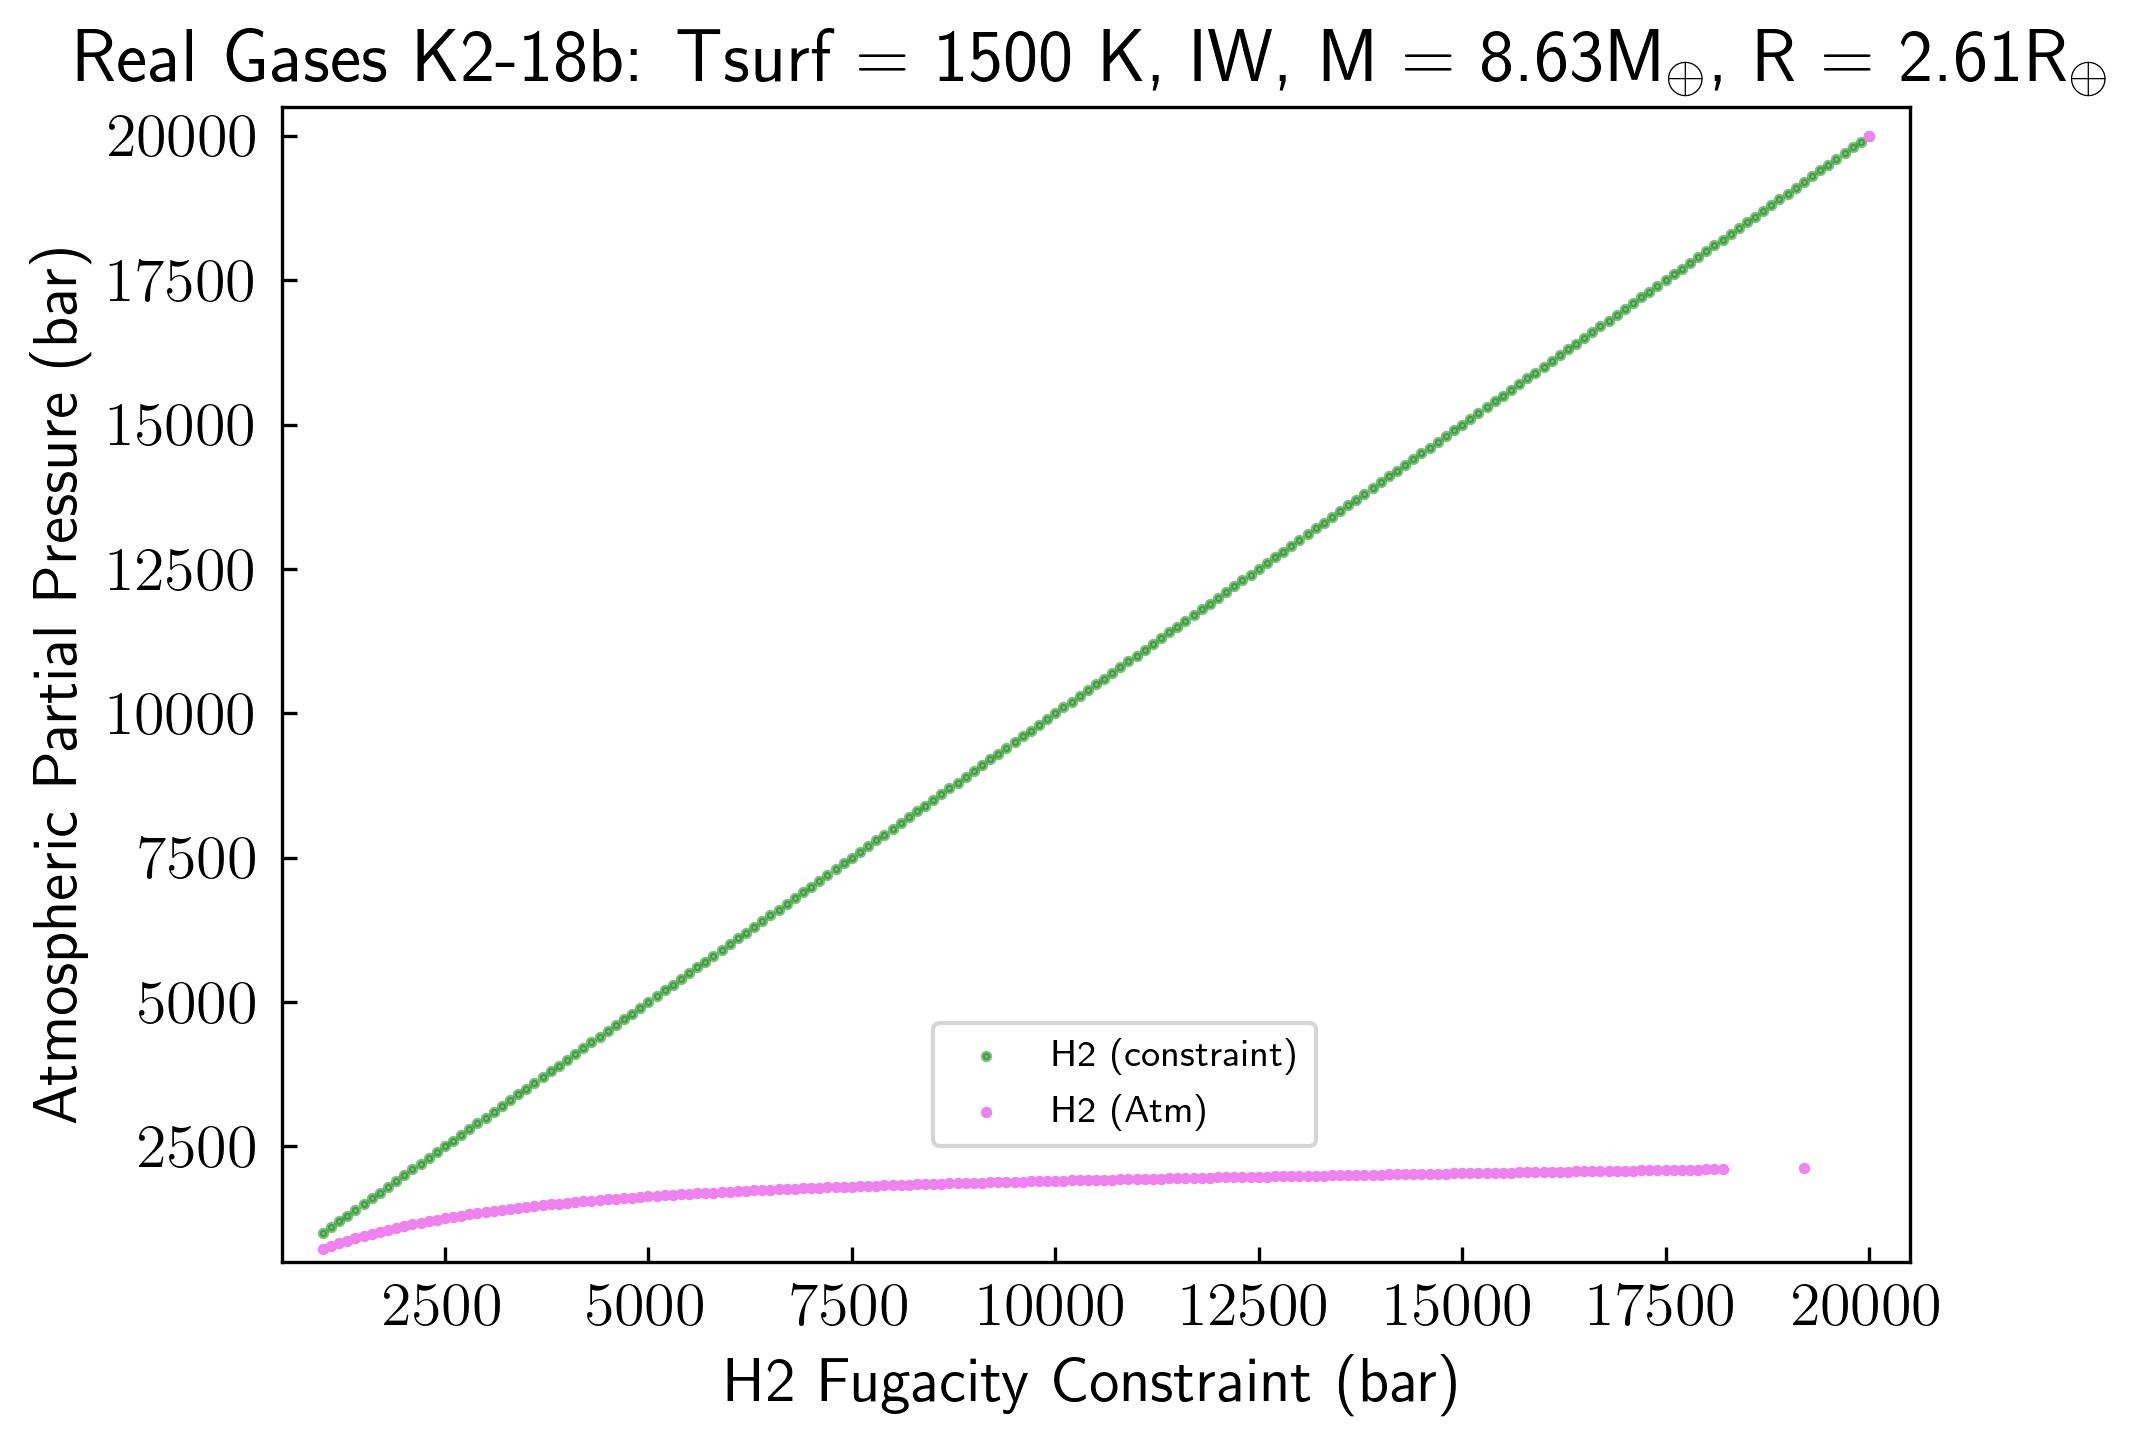

In [38]:
fig, ax = plt.subplots()
#ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2O, s=3, color='dodgerblue', label='H2O (Atm)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2_fugacity, s=3, color='green', alpha=0.5, label='H2 (constraint)')
ax.scatter(df_K218b_try.H2_fugacity, df_K218b_try.H2, s=3, color='violet', label='H2 (Atm)')

#ax2 = ax.twinx()
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2O_melt, color='dodgerblue', linestyle='--', label='H2O (Melt)')
#ax2.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2_melt, color='violet', linestyle='--', label='H2 (Melt)')
ax.set_xlim(500,20500)
ax.set_ylim(500,20500)

#ax3 = ax.twiny()
#ax3.plot(df_K218b_try.H2_fugacity, df_K218b_try.H2)
#ax3.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_xlabel(r'H2 Fugacity Constraint (bar)')
ax.set_ylabel('Atmospheric Partial Pressure (bar)')
#ax2.set_ylabel('Concentration in Melt (ppmw)')
#ax.set_yscale('log')
#ax2.set_yscale('log')

ax.legend(fontsize=9, loc=(0.4, 0.1))
ax2.legend(fontsize=6, loc=(0.6, 0.1))
plt.title(r'Real Gases K2-18b: Tsurf = 1500 K, IW, M = 8.63M$_\oplus$, R = 2.61R$_\oplus$')
#plt.savefig('data/Plots/K218b_CHOSpecies_1500K_IW_IdealGas_Pupto2GPa_H2Check_onlyFugacityConstraints.jpg', dpi=1000, bbox_inches='tight')
plt.show()